# Oil & Gas Production Forecasting — LSTM Model

### How LSTM Works:
1. **Sequential Modeling:**
LSTMs take one data point at a time (for example, daily temperatures) and try to learn patterns across time—like trends or seasonality.

2. **Memory Cells:**
LSTM networks have special “cells” that can store or forget information using “gates”:
- Input Gate: Decides what new info to store.
- Forget Gate: Decides what info to throw away.
- Output Gate: Decides what info to output.

3. **Capturing Dependencies:**
Unlike simple RNNs, LSTMs can capture long-term dependencies—for example, the effect of a sales campaign months ago on current sales.





### 1.Imports and dataset loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import optuna
import json
import os

sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("../data/processed/oil_production_features.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.Feature + target selection

In [4]:
features = df.drop(['period', 'target'], axis=1).columns.tolist()

X = df[features].values
y = df['target'].values

### 3.Train-test split

In [5]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 4.Scaling

In [6]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

### 5. Reshape for LSTM input

In [7]:
# LSTM expects (samples, timesteps, features)
# We use 1 timestep (current + lagged + rolling context)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

### 6.Hyperparameter tuning with Optuna

In [8]:
def objective(trial):
    model = Sequential()
    model.add(LSTM(
        units=trial.suggest_int('units', 32, 128),
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        return_sequences=False
    ))
    model.add(Dropout(trial.suggest_float('dropout', 0.1, 0.5)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(
        X_train_scaled, y_train_scaled,
        epochs=trial.suggest_int('epochs', 10, 50),
        batch_size=trial.suggest_int('batch_size', 16, 64),
        verbose=0,
        callbacks=[EarlyStopping(monitor='loss', patience=5)]
    )
    
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-05-15 20:03:51,166] A new study created in memory with name: no-name-8459c97b-6951-4a20-b104-30ff08694b99
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-05-15 20:03:53,976] Trial 0 finished with value: 201.7219942533053 and parameters: {'units': 84, 'dropout': 0.3641422468639436, 'epochs': 16, 'batch_size': 56}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-15 20:03:57,490] Trial 1 finished with value: 371.78434401292066 and parameters: {'units': 74, 'dropout': 0.39852381566517237, 'epochs': 47, 'batch_size': 52}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017E3B3AA980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:04:00,792] Trial 2 finished with value: 213.21674053485577 and parameters: {'units': 104, 'dropout': 0.4007306989789131, 'epochs': 32, 'batch_size': 55}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:04:03,752] Trial 3 finished with value: 239.98411677433893 and parameters: {'units': 128, 'dropout': 0.265637872047859, 'epochs': 33, 'batch_size': 47}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:04:06,312] Trial 4 finished with value: 212.39129638671875 and parameters: {'units': 110, 'dropout': 0.1654905954746272, 'epochs': 33, 'batch_size': 20}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-05-15 20:04:08,738] Trial 5 finished with value: 704.9582942082332 and parameters: {'units': 72, 'dropout': 0.21994696016413925, 'epochs': 10, 'batch_size': 62}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:04:11,161] Trial 6 finished with value: 315.74754920372595 and parameters: {'units': 101, 'dropout': 0.3514314563333276, 'epochs': 20, 'batch_size': 23}. Best is trial 0 with value: 201.7219942533053.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-15 20:04:14,037] Trial 7 finished with value: 199.49820650540866 and parameters: {'units': 76, 'dropout': 0.2373074795250526, 'epochs': 46, 'batch_size': 42}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-15 20:04:17,052] Trial 8 finished with value: 220.80839655949518 and parameters: {'units': 91, 'dropout': 0.4051300825521781, 'epochs': 25, 'batch_size': 57}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-15 20:04:19,973] Trial 9 finished with value: 373.0777775691106 and parameters: {'units': 41, 'dropout': 0.3206249064338419, 'epochs': 24, 'batch_size': 42}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:04:22,851] Trial 10 finished with value: 325.03724083533655 and parameters: {'units': 52, 'dropout': 0.12423643071961286, 'epochs': 47, 'batch_size': 32}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-15 20:04:26,124] Trial 11 finished with value: 338.2461970402644 and parameters: {'units': 59, 'dropout': 0.4661132611418186, 'epochs': 41, 'batch_size': 35}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-15 20:04:28,692] Trial 12 finished with value: 217.6736356295072 and parameters: {'units': 84, 'dropout': 0.27927619965241257, 'epochs': 11, 'batch_size': 45}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-15 20:04:31,826] Trial 13 finished with value: 215.27082707331732 and parameters: {'units': 64, 'dropout': 0.2234341479473369, 'epochs': 41, 'batch_size': 64}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:04:34,603] Trial 14 finished with value: 221.4972440279447 and parameters: {'units': 89, 'dropout': 0.49674197693244837, 'epochs': 19, 'batch_size': 35}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-15 20:04:37,046] Trial 15 finished with value: 382.3231858473558 and parameters: {'units': 42, 'dropout': 0.34272623566984106, 'epochs': 41, 'batch_size': 50}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:04:39,791] Trial 16 finished with value: 209.13806621844952 and parameters: {'units': 122, 'dropout': 0.22233746855813355, 'epochs': 16, 'batch_size': 27}. Best is trial 7 with value: 199.49820650540866.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:04:43,027] Trial 17 finished with value: 192.6622079702524 and parameters: {'units': 73, 'dropout': 0.16545500320152884, 'epochs': 50, 'batch_size': 39}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:04:45,553] Trial 18 finished with value: 203.78987004206732 and parameters: {'units': 68, 'dropout': 0.11894215409049161, 'epochs': 50, 'batch_size': 39}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-15 20:04:48,610] Trial 19 finished with value: 198.73577880859375 and parameters: {'units': 53, 'dropout': 0.16137412396523684, 'epochs': 38, 'batch_size': 29}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-15 20:04:52,853] Trial 20 finished with value: 284.26797250600964 and parameters: {'units': 51, 'dropout': 0.18189825903697004, 'epochs': 37, 'batch_size': 16}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-15 20:04:55,921] Trial 21 finished with value: 256.2060359074519 and parameters: {'units': 53, 'dropout': 0.15929977920439556, 'epochs': 45, 'batch_size': 29}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:04:58,742] Trial 22 finished with value: 231.79313307542068 and parameters: {'units': 78, 'dropout': 0.1961300353659039, 'epochs': 50, 'batch_size': 39}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:01,563] Trial 23 finished with value: 249.33034104567307 and parameters: {'units': 63, 'dropout': 0.266735586659305, 'epochs': 37, 'batch_size': 35}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-15 20:05:04,402] Trial 24 finished with value: 199.13659198467548 and parameters: {'units': 57, 'dropout': 0.1045562958875916, 'epochs': 44, 'batch_size': 44}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:07,343] Trial 25 finished with value: 362.0633544921875 and parameters: {'units': 34, 'dropout': 0.1067545663851358, 'epochs': 37, 'batch_size': 27}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-15 20:05:10,053] Trial 26 finished with value: 308.18860802283655 and parameters: {'units': 45, 'dropout': 0.1407496870115583, 'epochs': 44, 'batch_size': 46}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:05:12,632] Trial 27 finished with value: 336.0767258864183 and parameters: {'units': 59, 'dropout': 0.14998115769655945, 'epochs': 43, 'batch_size': 31}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-15 20:05:15,738] Trial 28 finished with value: 444.35506497896637 and parameters: {'units': 32, 'dropout': 0.18282886930389247, 'epochs': 28, 'batch_size': 23}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:05:19,024] Trial 29 finished with value: 201.07185715895432 and parameters: {'units': 57, 'dropout': 0.1380338164275843, 'epochs': 39, 'batch_size': 38}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:23,203] Trial 30 finished with value: 298.6312490609976 and parameters: {'units': 46, 'dropout': 0.10171828785883685, 'epochs': 49, 'batch_size': 42}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-05-15 20:05:26,385] Trial 31 finished with value: 203.7325955904447 and parameters: {'units': 70, 'dropout': 0.24022435557250585, 'epochs': 46, 'batch_size': 44}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:05:29,532] Trial 32 finished with value: 240.0358370267428 and parameters: {'units': 80, 'dropout': 0.200050762201194, 'epochs': 48, 'batch_size': 49}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-15 20:05:32,586] Trial 33 finished with value: 252.76813213641827 and parameters: {'units': 77, 'dropout': 0.17097166593033802, 'epochs': 44, 'batch_size': 52}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-05-15 20:05:35,454] Trial 34 finished with value: 219.74562424879807 and parameters: {'units': 66, 'dropout': 0.2464979719899356, 'epochs': 47, 'batch_size': 42}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:38,181] Trial 35 finished with value: 216.91176194411057 and parameters: {'units': 89, 'dropout': 0.3063754406493384, 'epochs': 42, 'batch_size': 37}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-15 20:05:40,971] Trial 36 finished with value: 198.79457444411057 and parameters: {'units': 73, 'dropout': 0.20469216155008263, 'epochs': 35, 'batch_size': 56}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:43,781] Trial 37 finished with value: 256.0680495042067 and parameters: {'units': 99, 'dropout': 0.1979808225191575, 'epochs': 34, 'batch_size': 58}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:05:46,903] Trial 38 finished with value: 244.58167912409857 and parameters: {'units': 73, 'dropout': 0.1338474739520879, 'epochs': 31, 'batch_size': 55}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:50,235] Trial 39 finished with value: 225.17537747896634 and parameters: {'units': 61, 'dropout': 0.15765377936087172, 'epochs': 34, 'batch_size': 53}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-15 20:05:53,259] Trial 40 finished with value: 292.63826810396637 and parameters: {'units': 56, 'dropout': 0.1765362789505589, 'epochs': 29, 'batch_size': 61}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-15 20:05:56,262] Trial 41 finished with value: 264.33760422926684 and parameters: {'units': 83, 'dropout': 0.2412774357814601, 'epochs': 36, 'batch_size': 50}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-05-15 20:05:59,131] Trial 42 finished with value: 203.9002685546875 and parameters: {'units': 73, 'dropout': 0.21190092951261863, 'epochs': 39, 'batch_size': 48}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:06:01,982] Trial 43 finished with value: 206.71159480168268 and parameters: {'units': 94, 'dropout': 0.1201160664045391, 'epochs': 39, 'batch_size': 33}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-15 20:06:05,231] Trial 44 finished with value: 363.68698354867786 and parameters: {'units': 84, 'dropout': 0.2651934442408955, 'epochs': 45, 'batch_size': 42}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-15 20:06:08,214] Trial 45 finished with value: 215.95450063852164 and parameters: {'units': 69, 'dropout': 0.14824688842714628, 'epochs': 48, 'batch_size': 60}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-05-15 20:06:11,058] Trial 46 finished with value: 448.8291719876803 and parameters: {'units': 49, 'dropout': 0.2876331117411148, 'epochs': 40, 'batch_size': 24}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-15 20:06:14,011] Trial 47 finished with value: 230.74946476862982 and parameters: {'units': 111, 'dropout': 0.42528670330549545, 'epochs': 35, 'batch_size': 44}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-15 20:06:16,781] Trial 48 finished with value: 319.25061974158655 and parameters: {'units': 37, 'dropout': 0.22935962537055618, 'epochs': 43, 'batch_size': 36}. Best is trial 17 with value: 192.6622079702524.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step


[I 2025-05-15 20:06:20,082] Trial 49 finished with value: 194.6915564903846 and parameters: {'units': 76, 'dropout': 0.20596731570079424, 'epochs': 46, 'batch_size': 33}. Best is trial 17 with value: 192.6622079702524.


In [9]:
# Save best hyperparameters.
best_params = study.best_params
with open('../models/lstm_best_params.json', 'w') as f:
    json.dump(best_params, f)

### 7.Train final LSTM model

In [10]:
model = Sequential()
model.add(LSTM(
    units=best_params['units'],
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    return_sequences=False
))
model.add(Dropout(best_params['dropout']))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit(
    X_train_scaled, y_train_scaled,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=[EarlyStopping(monitor='loss', patience=5)]
)

y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

Epoch 1/50


c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1579
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 16/50
11/1

### 8.Standardized evaluation metrics

In [11]:
metrics = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "R2": r2_score(y_test, y_pred),
    "MAPE": np.mean(np.abs((y_test - y_pred) / y_test)) * 100
}
print(metrics)

results = {"model": "LSTM", "metrics": metrics}
with open('../results/lstm_results.json', 'w') as f:
    json.dump(results, f)

test_periods = df['period'].iloc[train_size:]
pd.DataFrame({"ds": test_periods, "y_true": y_test, "y_pred": y_pred.flatten()}).to_csv(
    "../results/lstm_predictions.csv", index=False
)

{'MAE': 205.29331618088943, 'MSE': 130414.75569005654, 'RMSE': np.float64(361.1298321795868), 'R2': 0.9256297014311178, 'MAPE': np.float64(20.52455409018395)}


### 9.Plot predictions

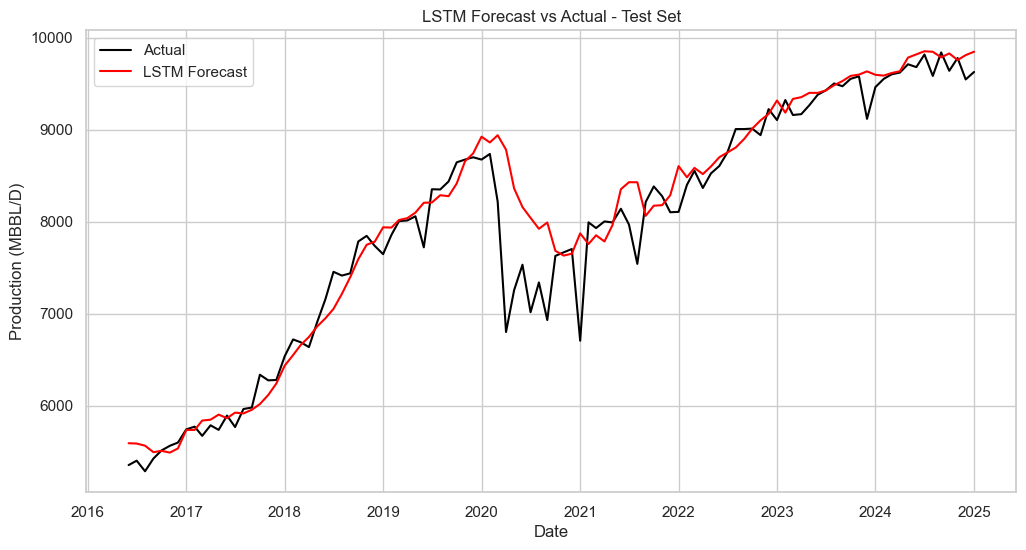

In [12]:
plt.figure(figsize=(12,6))
plt.plot(test_periods, y_test, label='Actual', color='black')
plt.plot(test_periods, y_pred, label='LSTM Forecast', color='red')
plt.title("LSTM Forecast vs Actual - Test Set")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

We used a multivariate feature dataset including lagged values, rolling windows, and temporal signals to train an LSTM deep learning model.
Bayesian optimization (Optuna) tuned the model architecture (units, dropout, batch size, epochs).
Results were saved identically to other models for unified comparison in 07_model_comparison.ipynb